In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [12]:
def create_k_folds(train, k):
    train = train.sample(frac=1)
    folds = []
    for i in range(k):
        folds.append(train[i*len(train)//k : (i+1)*len(train)//k])
    for i in range(k):
        
        expected = pd.DataFrame().assign(label=folds[i]['label'])
        expected.to_csv('./k-fold/expected_' + str(i) + '.csv', index=False)

        new_test = folds[i]
        new_test.drop(['label'], axis=1).to_csv('./k-fold/test_' + str(i) + '.csv', index=False)

        new_train = pd.concat(folds[:i] + folds[i+1:])
        new_train.to_csv('./k-fold/train_' + str(i) + '.csv', index=False)

In [14]:
def run_PCA(folds, alpha, k):
    for i in range(folds):
        subprocess.run(['./PCA', f'./k-fold/train_{i}.csv', f'./k-fold/test_{i}.csv', f'./k-fold/out_{i}.csv', str(alpha), str(k)])

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
folds = 10
alpha = 25
k = 3
create_k_folds(train, folds)
run_PCA(folds, alpha, k)

In [42]:
accuracy = []
confusion = np.zeros((10, 10), dtype=int)
for i in range(folds):
    out = pd.read_csv(f'./k-fold/out_{i}.csv')
    expected = pd.read_csv(f'./k-fold/expected_{i}.csv')
    for j in range(len(out)):
        confusion[int(expected.iloc[[j]]['label'])][int(out.iloc[[j]]['Label'])] += 1
    accuracy.append(sum(out['Label'] == expected['label'])/len(out))

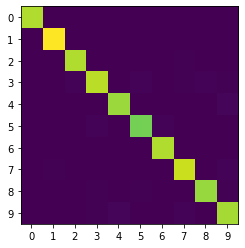

In [46]:
plt.imshow(confusion)
plt.xticks(np.arange(0,10))
plt.yticks(np.arange(0,10));